# Multinomial logistic regression

Multinomial logistic regression is used to predict categorical placement in or the probability of category membership on a dependent variable based on multiple independent variables. The independent variables can be either dichotomous (i.e., binary) or continuous (i.e., interval or ratio in scale). Multinomial logistic regression is a simple extension of binary logistic regression that allows for more than two categories of the dependent or outcome variable. Like binary logistic regression, multinomial logistic regression uses maximum likelihood estimation to evaluate the probability of categorical membership.   

Multinomial logistic regression does necessitate careful consideration of the sample size and examination for outlying cases. Like other data analysis procedures, initial data analysis should be thorough and include careful univariate, bivariate, and multivariate assessment. Specifically, multicollinearity should be evaluated with simple correlations among the independent variables. Also, multivariate diagnostics (i.e. standard multiple regression) can be used to assess for multivariate outliers and for the exclusion of outliers or influential cases. Sample size guidelines for multinomial logistic regression indicate a minimum of 10 cases per independent variable (Schwab, 2002).  

In [31]:
%pip install numpy
%pip install ipywidgets
%pip install pandas
%pip install matplotlib
%pip install ipympl
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python\Python 379\python.exe -m pip install --upgrade pip' command.


In [1]:
import copy, math
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Output
from plt_overfit import overfit_example, output
from lab_utils_logistic import sigmoid
# plt.style.use('./deeplearning.mplstyle')

As any of the other regression algorithms we need a cost function, a gradient function and finally we will use it to do our approximation with the gradient descent algorithm.

### Cost function (logistic)
_____

We will reuse the same cost function that we developed for binary logistic regression

In [33]:
def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """

    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        if f_wb_i == 0:
          f_wb_i = 0.0000000000000001         
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
        
    cost = cost/m                                                      #scalar

    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          #scalar
    reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
    total_cost = cost + reg_cost                                       #scalar
    return total_cost    

Let´s test it just to make sure it is as expected.

In [34]:
np.random.seed(1)
X_tmp = np.random.rand(5,6)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1]).reshape(-1,)-0.5
b_tmp = 0.5
lambda_tmp = 0.7
cost_tmp = compute_cost_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print("Regularized cost:", cost_tmp)

Regularized cost: 0.6850849138741673


### Gradient function (logistic)
_____
We will also reuse the gradient function

In [35]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)            : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw  

Let's also test it.

In [36]:
np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"dj_db: {dj_db_tmp}", )
print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )

dj_db: 0.341798994972791
Regularized dj_dw:
 [0.17380012933994293, 0.32007507881566943, 0.10776313396851499]


### Gradient descent 
_____

In [37]:
def gradient_descent(X, y, w_in, b_in, alpha, r_lambda, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      r_lambda (float)     : Regularization rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic_reg(X, y, w, b, r_lambda)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic_reg(X, y, w, b, r_lambda) )
        
        pass
        
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history

In [135]:
x_train1 = np.random.rand(7,2)
y_train1 = np.array([0, 0, 0, 1, 1, 1, 1])

w_in = np.random.rand(x_train1.shape[1])
b_in = 0.5

alph = 0.1
r_lambda = 0.7
iters = 10000

w_out, b_out, _ = gradient_descent(x_train1, y_train1, w_in, b_in, alph, r_lambda, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.7023097124277004   
Iteration 1000: Cost 0.6802549543626335   
Iteration 2000: Cost 0.6802549543139016   
Iteration 3000: Cost 0.6802549543139015   
Iteration 4000: Cost 0.6802549543139015   
Iteration 5000: Cost 0.6802549543139016   
Iteration 6000: Cost 0.6802549543139016   
Iteration 7000: Cost 0.6802549543139016   
Iteration 8000: Cost 0.6802549543139016   
Iteration 9000: Cost 0.6802549543139016   

updated parameters: w:[ 0.2  -0.11], b:0.2729952540893822


## The changes

The implementation of Multiclass classification follows the same ideas as the binary classification. In multi-class classification, we have more than two classes. Here is an example. Say, we have different features and characteristics of cars, trucks, bikes, and boats as input features. Our job is to predict the label(car, truck, bike, or boat). We will treat each class as a binary classification problem; this approach is called the __one vs all method__.

In the one vs all method, when we work with a class, that class is denoted by 1 and the rest of the classes becomes 0. For example, if we have four classes: cars, trucks, bikes, and boats. When we will work on the car, we will use the car as 1 and the rest of the classes as zeros. Again, when we will work on the truck, the element of the truck will be one, and the rest of the classes will be zeros

| Car | Truck | Bike | Boat |
| --- | --- | --- | --- |
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 |


We will make one column for each of the classes with the same length as y. When the class is truck, we will make a column that has 1 for the rows with trucks and 0 otherwise.

We will create a function that will produce a temporary y vector that will only have 1's for the selected class, and 0's for the rest.

In [2]:
def y_change(y, cl):
    """
    Creates an independent y vector that only holds 1's for
    the selected class and zero for the rest
    
    Args:
      y (ndarray (m,)) : target values
      cl (scalar)      : The class we are studying.
      
    Returns:
      y_pr (ndarray (n,))   : Array holding only 1's for the 
                              analyzed class.
    """
    y_pr=[]
    for i in range(0, len(y)):
        if y[i] == cl:
            y_pr.append(1)
        else:
            y_pr.append(0)
    return y_pr

We will create a function that will produce the w values that will separate the i-th class

In [40]:
def find_param(X, y):
    """
    Creates the w_i vector for the given class.
    
    Args:
      X (ndarray (m,n)    : Data, m examples with n features
      y (ndarray (m,))    : Target values
      
    Returns:
      theta_list (ndarray (n,)) : This is a matrix that will hold a row for the w values
                                  for every i class. 
    """
    alph = 0.1
    r_lambda = 0.7
    iters = 1000

    y_uniq = list(set(y.flatten()))
    theta_list = []
    for i in y_uniq:
        w_in = np.random.rand(X.shape[1])
        b_in = 0.5

        y_tr = pd.Series(y_change(y, i))
        # y_tr = y_tr[:, np.newaxis]
        np.array(y_tr)[:, np.newaxis]
        print(f"\n\nWe will find the weights for class: {i}")
        theta1, _ , _ = gradient_descent(X, y_tr, w_in, b_in, alph, r_lambda, iters) 
        theta_list.append(theta1)
    return theta_list

Finally, we will create a function that should give us the proper class for every entry.

In [3]:
def predict(theta_list, X, y):
    y_uniq = list(set(y.flatten()))
    y_hat = [0]*len(y)
    for i in range(0, len(y_uniq)):
        y_tr = y_change(y, y_uniq[i])
        # y1 = sigmoid(x, theta_list[i])
        y1 = sigmoid(np.dot(X, theta_list[i]))
        for k in range(0, len(y)):
            # if type(y1) == list:
            if y_tr[k] == 1 and y1[k] >= .7:
                y_hat[k] = y_uniq[i]
            # else:
                # if y_tr[k] == 1 and y1 >= 0.2:
                    # y_hat[k] = y_uniq[i]
    return y_hat

Let's test it. First, we will create the list of our weights for each class.

In [42]:
import ast

In [43]:
x_train = []
y_train = []
f = open("features.csv", "r")
flag = True
for line in f.readlines():
    # x = ast.literal_eval(row[2])
        if "," in line:
            x = np.array(ast.literal_eval(line[line.index(",")+1:].replace("\"", "")))
            if flag:
                normval = np.linalg.norm(ast.literal_eval(line[line.index(",")+1:].replace("\"", "")))
                flag = False
            x_train.append(x/normval)
            # x_train.append(ast.literal_eval(line[line.index(",")+1:].replace("\"", "")))
            aux = line[0:line.index(",")]
            if aux == "duck":
                y_train.append(1)
            elif aux == "cat":
                y_train.append(2)
            elif aux == "panda":
                y_train.append(3)    
                
x_train = np.array(x_train) 
y_train = np.array(y_train) 
                 
theta_list = find_param(x_train, y_train)



We will find the weights for class: 1
Iteration    0: Cost 4.4505244743970005   
Iteration  100: Cost 1.2177257561137607   
Iteration  200: Cost 0.92157020440171   
Iteration  300: Cost 0.876728108245872   
Iteration  400: Cost 0.8426609431220008   
Iteration  500: Cost 0.8123826246508171   
Iteration  600: Cost 0.7856845554452349   
Iteration  700: Cost 0.762440211366606   
Iteration  800: Cost 0.7424553817172992   
Iteration  900: Cost 0.725475612826881   


We will find the weights for class: 2
Iteration    0: Cost 4.4296218938163525   
Iteration  100: Cost 1.208501576768145   
Iteration  200: Cost 0.9211161445091848   
Iteration  300: Cost 0.8788796284284768   
Iteration  400: Cost 0.8469371781055475   
Iteration  500: Cost 0.8185384481398426   
Iteration  600: Cost 0.7934770263580577   
Iteration  700: Cost 0.771629863637716   
Iteration  800: Cost 0.7528137459775134   
Iteration  900: Cost 0.736792093096052   


We will find the weights for class: 3
Iteration    0: Cost 5.16027

Now that we have it, we can run our prediction.

In [44]:
y_hat = predict(theta_list, x_train, y_train)
print(y_hat)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [139]:
print(normval)

4397.062097478376


In [130]:
# generar el csv
data = np.asarray(theta_list)
np.savetxt('theta.csv', data, delimiter=',')

In [8]:
normval = 4397.062097478376

# PREDICTING VALUES
from feature_extractor import *
x_t = []
# for i in range(241, 301):
f = "Images/tests/cat_{}.jpg".format(245)
image = Image.open(f)
r, g, b = mostRepeatedRGB(image)
features = r + g + b + mostRepeatedHSV(image) + mostRepeatedGrayscale(image)
# y_train = [0, 1, 2]
x_t = np.array([features, features, features])/normval
# y_train = np.array(y_train)

# LECTURA DE CSV
theta_lis = np.loadtxt("theta.csv", delimiter=",", dtype=float)
theta_lis = np.array(theta_lis)

y_hat = predict(theta_lis, x_t, np.array([2, 1, 3]))   #### theta_list funciona dentro de este notebook, theta_lis es leer del archivo
# print(i, y_hat)
f = f.split("/")
if f[2][:f[2].index("_")] == "cat":
    y_hat[0] = 0
    y_hat[1] = 1
    y_hat[2] = 0
if f[2][:f[2].index("_")] == "duck":
    y_hat[0] = 2
    y_hat[1] = 0
    y_hat[2] = 0




if y_hat[0] == 2 and y_hat[1] == 1 and y_hat[2] == 0:
    print("Panda")
elif y_hat[0] == 0 and y_hat[1] == 1:
    print("Cat")
elif y_hat[0] == 2:
    print("Duck")

Cat


We can now even observe the results.

ValueError: x and y must have same first dimension, but have shapes (720,) and (7,)

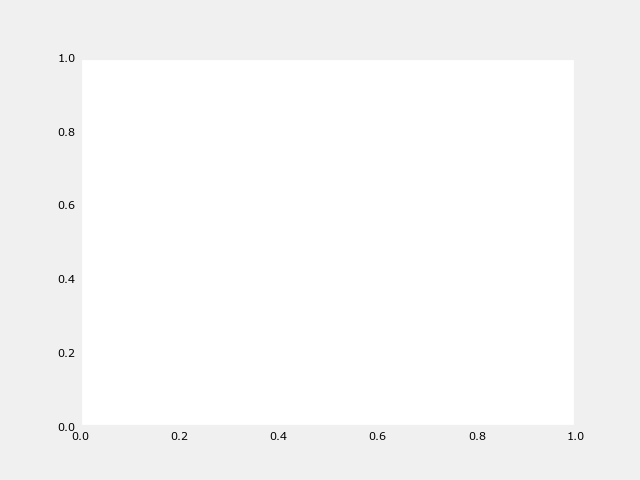

In [136]:
#Plotting the actual and predicted values
f1 = plt.figure()
c = [i for i in range (1,len(y_train)+1,1)]
plt.plot(c,y_train1,color='r',linestyle='-')
plt.plot(c,y_hat,color='b',linestyle='-')
plt.xlabel('Value')
plt.ylabel('Class')
plt.title('Actual vs. Predicted')
plt.show()

In [ ]:
#Plotting the error
f1 = plt.figure()
c = [i for i in range(1,len(y_train)+1,1)]
plt.plot(c,y_train1-y_hat,color='green',linestyle='-')
plt.xlabel('index')
plt.ylabel('Error')
plt.title('Error Value')
plt.show()

: 